In [1]:
from typing import TypedDict, Annotated, Sequence
from langgraph.graph import StateGraph, END
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_nvidia_ai_endpoints import ChatNVIDIA, NVIDIAEmbeddings
from langchain_chroma import Chroma
from langchain_community.document_loaders import PyPDFLoader
from operator import add as add_message
import os


In [ ]:

llm = ChatNVIDIA(
    model="meta/llama3-70b-instruct",
    nvidia_api_key="NVIDIA_API_KEY",
    temperature=0.3
)

embedding = NVIDIAEmbeddings(
    model="nvidia/nv-embedqa-e5-v5",
    model_type="passage",
    nvidia_api_key="NVIDIA_API_KEY"
)


In [14]:
pdf_path = "C:\\Users\\Akshar Savaliya\\Downloads\\Agentic_NN.pdf"
if not os.path.exists(pdf_path):
    raise FileNotFoundError(f"File not found: {pdf_path}")

pdf_loader = PyPDFLoader(pdf_path)
pages = pdf_loader.load()
print(f"PDF loaded successfully with {len(pages)} pages")

text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100)
documents = text_splitter.split_documents(pages)

vectorstore = Chroma.from_documents(documents, embedding)
db = Chroma.from_documents(documents, embedding, persist_directory="D:\\Corp8.AI\\Rag_Types")
print("PDF embedded and stored in Chroma.")

PDF loaded successfully with 27 pages
PDF embedded and stored in Chroma.


In [15]:
def retrieve_node(state):
    query = state["question"]
    retrieved_docs = db.similarity_search(query, k=4)
    return {"retrieved_docs": retrieved_docs}

def grade_node(state):
    graded = []
    for doc in state["retrieved_docs"]:
        score = 1.0 if "Agentic" in doc.page_content or "ANN" in doc.page_content else 0.3
        doc.metadata["score"] = score
        graded.append(doc)
    return {"graded_docs": graded}

In [24]:

def condition_check(state):
    if any(doc.metadata["score"] < 0.5 for doc in state["graded_docs"]):
        return "web_search"
    return "generate"

def web_search_node(state):
    # Fake external knowledge
    web_doc = type("Doc", (), {})()
    web_doc.page_content = "Textual backpropagation helps ANN improve coordination dynamically."
    web_doc.metadata = {"score": 1.0}
    return {"graded_docs": state["graded_docs"] + [web_doc]}

def generate_node(state):
    context = "\n\n".join([doc.page_content for doc in state["graded_docs"]])
    llm = ChatNVIDIA(
    model="meta/llama3-70b-instruct",
    nvidia_api_key="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",
    temperature=0.3
)
    prompt = f"Answer the question based on the following context:\n\n{context}\n\nQuestion: {state['question']}"
    response = llm.invoke(prompt)
    return {"final_answer": response.content}

In [25]:
class AgentState(TypedDict):
    question: str
    retrieved_docs: list
    graded_docs: list
    final_answer: str

initial_state = AgentState

graph = StateGraph(initial_state)

# Nodes
graph.add_node("retrieve", retrieve_node)
graph.add_node("grade_documents", grade_node)
graph.add_node("web_search", web_search_node)
graph.add_node("generate", generate_node)

# Edges
graph.set_entry_point("retrieve")
graph.add_edge("retrieve", "grade_documents")
graph.add_conditional_edges("grade_documents", condition_check, {
    "web_search": "web_search",
    "generate": "generate"
})
graph.add_edge("web_search", "generate")
graph.add_edge("generate", END)

# Step 4: Compile & Run

corrective_rag = graph.compile()

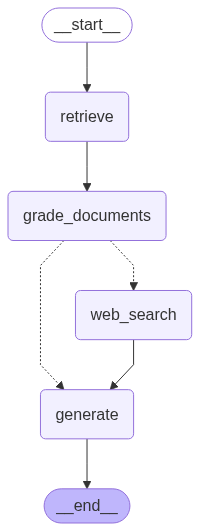

In [26]:
from IPython.display import Image, display
display(Image(corrective_rag.get_graph().draw_mermaid_png()))

In [27]:
result = corrective_rag.invoke({
    "question": "What is textual backpropagation in Agentic Neural Networks?"
})

print("\nAnswer:\n", result["final_answer"])


Answer:
 According to the context, textual backpropagation in Agentic Neural Networks refers to the process of backpropagating textual feedback to isolate errors and propose targeted adjustments. These textual critiques act like gradient signals, guiding prompt updates and connection refinements.
